## For the dataset used in project

# LFW dataset

In [39]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchvision import transforms

In [3]:
# Data read-in and cleaning
dataset_path = "C:/Users/Chris/Downloads/lfwDataset/lfw-deepfunneled/"

lfw_allnames = pd.read_csv(r"C:\Users\Chris\Downloads\lfwDataset\lfw_allnames.csv")


In [4]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

print(len(lfw_train))

10586


<AxesSubplot:>

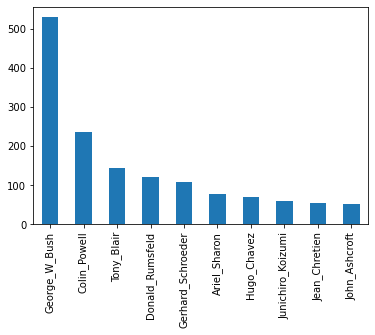

In [5]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

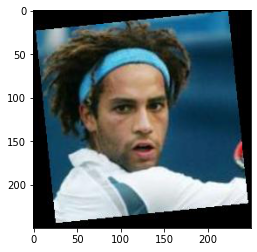

In [6]:
im = Image.open(dataset_path + str(lfw_train.image_path[0]))
plt.imshow(im)

First, we are testing to see whether the images are in category A or B using our model. We can recreate these conditions on a subset of the data, using the samples of George W Bush. The goal of this testing is to identify whether an image is George W Bush or not; we use a random sample of the other images for category B.

In [7]:
# Create a dataset for George W Bush
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [8]:
# split into training set, testing set and validation set
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [40]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('C:/Users/Chris/Downloads/lfwDataset/GWB/',dir_name)):
            shutil.os.mkdir(os.path.join('C:/Users/Chris/Downloads/lfwDataset/GWB/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('C:/Users/Chris/Downloads/lfwDataset/GWB/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('C:/Users/Chris/Downloads/lfwDataset/GWB/',dir_name,data_type))
        path_from = os.path.join('C:/Users/Chris/Downloads/lfwDataset/lfw-deepfunneled/',image)
        path_to = os.path.join('C:/Users/Chris/Downloads/lfwDataset/GWB/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
    print('Moved {} images to {} folder.'.format(co,dir_name))

In [41]:
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [28]:
num_epochs = 2
batchsize = 16
lr = 0.001


TRAIN_DATA_PATH = 'C:/Users/Chris/Downloads/lfwDataset/GWB/Bush_train/'
VAL_DATA_PATH = 'C:/Users/Chris/Downloads/lfwDataset/GWB/Bush_val/'
TEST_DATA_PATH = 'C:/Users/Chris/Downloads/lfwDataset/GWB/Bush_test/'

## using the transform class to resize, chop the black boader and normalize our data. 
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(50),
    transforms.CenterCrop(0.8*50),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])

train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True,  num_workers=4)

val_data = torchvision.datasets.ImageFolder(root=VAL_DATA_PATH, transform=TRANSFORM_IMG)
val_data_loader = DataLoader(val_data, batch_size= batchsize, shuffle= False,  num_workers=4)

test_data = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = DataLoader(test_data, batch_size= batchsize, shuffle=True, num_workers=4) 


In [40]:
total_train_samples = len(train_data)
n_train_iterations = math.ceil(total_train_samples / batchsize)
print(total_train_samples, n_train_iterations)

total_val_samples = len(val_data)
n_val_iterations = math.ceil(total_val_samples / batchsize)
print(total_val_samples, n_val_iterations)


678 43
170 11


In [41]:
# Implementation of CNN/ConvNet Model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 40, 40, 3)
        # Conv -> (?, 40, 40, 32)
        # Pool -> (?, 20, 20, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
            
        # L2 ImgIn shape=(?, 20, 20, 32)
        # Conv      ->(?, 20, 20, 64)
        # Pool      ->(?, 10, 10, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
            
            
        # L4 FC 10x10x64 inputs -> 64 outputs
        self.fc1 = torch.nn.Linear(10 * 10 * 64, 64, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU())
            
        # L5 Final FC 64 inputs -> 2 outputs
        self.fc2 = torch.nn.Linear(64, 2, bias=True)
            
        #torch.nn.init.normal_(self.fc2, mean=0.0, std= 0.5)
        torch.nn.init.xavier_uniform_(self.fc2.weight) # initialize parameters
        

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out


#instantiate CNN model
model = CNN()
model

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=6400, out_features=64, bias=True)
  (layer4): Sequential(
    (0): Linear(in_features=6400, out_features=64, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [43]:
# Loss and Optimizer
CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the Model
for epoch in range(num_epochs):
    
    print(f'Training-epoch:{epoch} is processing')
    for i, batch in enumerate(train_data_loader):
        images, labels = batch
        optimizer.zero_grad()
        outputs = model(images)
        loss = CEL(outputs,labels)
        if (i+1) % 5 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_train_iterations}, inputs: {images.shape}')
            print("loss", loss.item(), '\n')
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        print(f'Val-epoch:{epoch} is processing')
        for i, batch in enumerate(val_data_loader):
            images, labels = batch
            optimizer.zero_grad()
            outputs = model(images)
            loss = CEL(outputs, labels)
            if (i+1) % 5 == 0:
                print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_val_iterations}, inputs: {images.shape}')
                print("val-loss", loss.item(), '\n')
                

# Test the Model
model.eval()  # Change model to 'eval' mode (BN uses moving mean/var)
correct = 0
total = 0
for images, labels in test_data_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on test images: %.4f%%' % (100.0*correct/total))



Training-epoch:0 is processing
epoch 1/2, step 5/43, inputs: torch.Size([16, 3, 40, 40])
loss 0.39149144291877747 

epoch 1/2, step 10/43, inputs: torch.Size([16, 3, 40, 40])
loss 0.37205830216407776 

epoch 1/2, step 15/43, inputs: torch.Size([16, 3, 40, 40])
loss 0.41370677947998047 

epoch 1/2, step 20/43, inputs: torch.Size([16, 3, 40, 40])
loss 0.4707823395729065 

epoch 1/2, step 25/43, inputs: torch.Size([16, 3, 40, 40])
loss 0.2337716966867447 

epoch 1/2, step 30/43, inputs: torch.Size([16, 3, 40, 40])
loss 0.4857306480407715 

epoch 1/2, step 35/43, inputs: torch.Size([16, 3, 40, 40])
loss 0.5223290324211121 

epoch 1/2, step 40/43, inputs: torch.Size([16, 3, 40, 40])
loss 0.524539589881897 

Val-epoch:0 is processing
epoch 1/2, step 5/11, inputs: torch.Size([16, 3, 40, 40])
val-loss 0.36733153462409973 

epoch 1/2, step 10/11, inputs: torch.Size([16, 3, 40, 40])
val-loss 0.15949919819831848 

Training-epoch:1 is processing
epoch 2/2, step 5/43, inputs: torch.Size([16, 3, 40,